In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import idx2numpy
import numpy as np
import heapq

In [6]:
X_train = idx2numpy.convert_from_file("data/train-images-idx3-ubyte")
Y_train = idx2numpy.convert_from_file("data/train-labels-idx1-ubyte")
X_test = idx2numpy.convert_from_file("data/t10k-images-idx3-ubyte")
Y_test = idx2numpy.convert_from_file("data/t10k-labels-idx1-ubyte")

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
# Normalize the data
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(X_train)
X_test_data_minmax = MinMaxScaler.fit_transform(X_test)

In [7]:
def subsample_training(X, Y, M, return_id = False):
    from numpy.random import default_rng
    assert X.shape[0] == Y.shape[0]
    assert M < X.shape[0]
    rng = default_rng()
    idxs = rng.choice(X.shape[0], size=M, replace=False)
    if return_id:
        return X.take(idxs, axis=0), Y.take(idxs, axis=0), idxs
    else:
        return X.take(idxs, axis=0), Y.take(idxs, axis=0)


In [61]:
def remove_outliers(X, Y):
    knn_clf=KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    knn_clf.fit(X, Y)
    ypred=knn_clf.predict(X)
    outliers = ypred != Y
    # remove outliers
    X, Y = X[~outliers], Y[~outliers]
    return X, Y


def keep_useful(X, Y):
    useful_X, useful_Y = [], []
    labels_vis = set()
    for x, y in zip(X, Y):
        if y not in labels_vis:
            useful_X.append(x)
            useful_Y.append(y)
            labels_vis.add(y)
        else:
            # Check if the value is misclassified
            #import ipdb;ipdb.set_trace()
            knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
            knn_clf.fit(useful_X, useful_Y)
            ypred=knn_clf.predict([x])
            if ypred[0] != y:
                useful_X.append(x)
                useful_Y.append(y)
    return useful_X, useful_Y   

def distance(x1, x2):
    return np.sum((x1-x2)**2)

def preprocess_pair_wise_distance(X, Y):
    distances = []
    for i, (xs1, _) in enumerate(zip(X, Y)):
        euc_sum = 0.
        for j, (xs2, _) in enumerate(zip(X, Y)):
            if i == j:
                continue
            euc_sum += distance(xs1, xs2)            
        distances.append(euc_sum)
    return distances
    

def get_max_distance_idx(distances):    
    max_distance, max_idx = -1., None
    for idx, euc_sum in enumerate(distances):
        if max_distance < euc_sum:
            max_distance = euc_sum
            max_idx = idx 
    return max_idx        

    

def update_distances(X, Y, idx, xn, distances):
    xo = X[idx]
    new_dis_sum = 0.
    for i, euc_sum in enumerate(distances):
        if i == idx:
            continue
        ns = distance(xn, X[i])
        new_dis_sum += ns
        euc_sum -= distance(xo, X[i])
        euc_sum += ns
        distances[i] = euc_sum
    distances[idx] = new_dis_sum
    return distances



def iteratively_select_best_information(X, Y, M):
    # Initialize randomly
    Xs, Ys, idxs = subsample_training(X, Y, M, return_id=True)
    # Calculate the sum of pairwise distance for each of the sample
    distances = preprocess_pair_wise_distance(Xs, Ys)
    for i, (x, y) in enumerate(zip(X, Y)):
        if i not in idxs:
            knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
            knn_clf.fit(Xs, Ys)
            ypred=knn_clf.predict([x])
            if y != ypred:
                # This is useful, insert this and remove the least useful information,
                # remove the max_distance from the Xs, Ys from the real data distribution.
                idx = get_max_distance_idx(distances)
                distances = update_distances(Xs, Ys, idx, x, distances)
                Xs[idx] = x
                Ys[idx] = y
    return Xs, Ys            



def prototype_selection(X, Y):
    orignal_sz = len(Y)
    X, Y = remove_outliers(X, Y)
    X, Y = keep_useful(X, Y)
    print(f"Factor by which the dataset is reduces is {orignal_sz/len(Y)} ")
    return X, Y

In [59]:
def predict_values_and_calculate_accuracy_uniform_random(M):
    # 1 NN, distance = Euclidian
    knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    X, Y = subsample_training(X_data_minmax, Y_train, M)
    knn_clf.fit(X, Y)
    ypred=knn_clf.predict(X_test_data_minmax)
    # result = confusion_matrix(Y_test, ypred)
    # print("Confusion Matrix:")
    # print(result)
    # result1 = classification_report(Y_test, ypred)
    # print("Classification Report:",)
    # print (result1)
    result2 = accuracy_score(Y_test,ypred)
    # print(type(result1))
    print("Accuracy:",result2)
    return result2

def predict_values_and_calculate_accuracy_prototype_subset(Xs, Ys):
    # 1 NN, distance = Euclidian
    knn_clf=KNeighborsClassifier(n_neighbors=1, metric="euclidean")
    #X, Y = subsample_training(X_data_minmax, Y_train, M)
    # X, Y = prototype_selection(X, Y)

    knn_clf.fit(Xs, Ys)
    ypred=knn_clf.predict(X_test_data_minmax)
    # result = confusion_matrix(Y_test, ypred)
    # print("Confusion Matrix:")
    # print(result)
    #result1 = classification_report(Y_test, ypred)
    #print("Classification Report:",)
    #print (result1)
    result2 = accuracy_score(Y_test,ypred)
    #print("Accuracy:",result2)
    return result2




In [63]:
predict_values_and_calculate_accuracy_prototype_subset(XP, YP)

0.9378

In [66]:
import pickle
with open("prototype_X.pkl", "wb") as fd:
    pickle.dump(XP, fd)
with open("prototype_Y.pkl", "wb") as fd:
    pickle.dump(XY, fd)    

[]

In [34]:
import pickle
with open("prototype_X.pkl", "rb") as fd:
    XP = pickle.load( fd)
with open("prototype_Y.pkl", "rb") as fd:
    YP = pickle.load(fd)   

In [81]:
def test_multiple_iterations(num_iterations=5):
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots()
    Ms = [1000, 3000, 5000, 10000]
    means = []
    mean_p2std = [ ]
    mean_n2std = [ ]
    accuracies_prototype_selection = []
    for i, M in enumerate(Ms):
        XP1, YP1 = iteratively_select_best_information(X_data_minmax, Y_train, M)
        accuracies_prototype_selection.append(predict_values_and_calculate_accuracy_prototype_subset(XP1, YP1)) 
        accuracies_uniform = []        
        for i in range(num_iterations):
            accuracies_uniform.append(predict_values_and_calculate_accuracy_uniform_random(M))
        mean, std = np.mean(accuracies_uniform), np.std(accuracies_uniform)
        print(mean, std)
        means.append(mean)
        mean_p2std.append(mean+2*std)
        mean_n2std.append(mean-2*std)            
    ax.fill_between(Ms, mean_n2std, mean_p2std, alpha=0.3, label="confidence region")
    ax.plot(Ms, means, "g",label="mean of uniform random")# the label locations
    ax.plot(Ms, accuracies_prototype_selection, label="prototype_accuaracy")
    ax.set_ylim(0.8, 1.0)

    plt.legend()
    plt.show()    

Accuracy: 0.8797
Accuracy: 0.8874
Accuracy: 0.8857
Accuracy: 0.883
Accuracy: 0.8856
0.8842800000000001 0.002687303481187032
Accuracy: 0.9212
Accuracy: 0.9225
Accuracy: 0.9299
Accuracy: 0.9185
Accuracy: 0.9207
0.92256 0.003890295618587345
Accuracy: 0.9324
Accuracy: 0.9344
Accuracy: 0.9341
Accuracy: 0.9345
Accuracy: 0.9338
0.93384 0.0007605261336732632
Accuracy: 0.948
Accuracy: 0.9489
Accuracy: 0.9481
Accuracy: 0.9472
Accuracy: 0.9482
0.94808 0.0005418486873657423


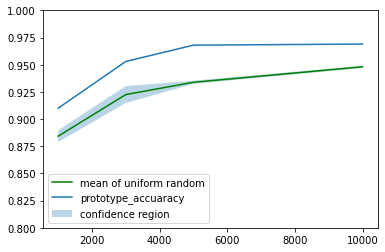

In [82]:
test_multiple_iterations(5)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy: 0.9691


In [24]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]],
              [[3, 4, 5, 6], [5, 6, 7, 8]],
              [[4, 4, 5, 6], [5, 6, 7, 9]]])
#x[np.array([0, 1, 1], dtype="bool")]
x.take([1,2], axis=0)

array([[[3, 4, 5, 6],
        [5, 6, 7, 8]],

       [[4, 4, 5, 6],
        [5, 6, 7, 9]]])